# HW 5

### Import Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

from torch.autograd import Variable

from torch import optim
from torchvision.transforms import ToTensor

## Data loader

here we have imported the training and testing data
</br> we have taken 100 Training sample batch  and 10 testing samples batch

In [3]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

from torchvision import datasets, transforms

T = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

train_d = datasets.MNIST('./data', train=True, download=True, transform = T )
val_d = datasets.MNIST('./data', train=False, download=True, transform = T)

num_batch_train = 100

num_batch_test = 10

train_data = torch.utils.data.DataLoader(train_d, batch_size = num_batch_train, shuffle=True)
test_data = torch.utils.data.DataLoader(val_d , batch_size = num_batch_test ,shuffle=False)

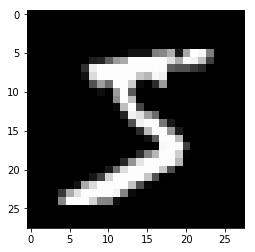

In [4]:
plt.imshow(train_d[0][0][0],cmap = 'gray')

### CNN 

In [5]:
class CNN(nn.Module):
    
    def __init__(self):
        """
        Here We are initializing all the convolution Layer with Kernel Size 5*5*4 keeping the dimension same,
        Max Pool Layer with stride 2,
        Hidden Layer 1 with  49 Nodes
        Output Layer with 10 Nodes
        
        """
        super(CNN, self).__init__()
        
        # Convolution Layer 1 with input channel =1 , output channels  = 4 , Kernel Size = 5*5 , Padding as 2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
        # ReLU activation
        self.relu1 = nn.ReLU()
        
        # Max Pooling with Size = 2 and stride = 2
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        # Convolution Layer 2 with input channel =4 , output channels  = 4 , Kernel Size = 5*5 , Padding as 2
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        
        # Max Pooling with Size = 2 and stride = 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        
        # Flatten Layer:- 7x7x4 --> 196x1
        self.flatten = nn.Flatten()
        
        # Hidden Layer 1 with 49 Node 
        self.fullyconnected1 = nn.Linear(7*7*4, 49)
        # Relu Activation
        self.relumlp = nn.ReLU()
        
        # Hidden Layer 2 with 10 Output Nodes
        self.fullyconnected2 = nn.Linear(49, 10)

        
    def forward(self, out):
        """
        Convolution layer 1 --> Relu --> Maxpooling Layer 1 --> Convolution Layer 2 --> Relu --> MaxPooling Layer 2
            --> Flattening Layer --> Hidden Layer 1 --> ReLU --> Softmax --> Output (1*10)
            
        Input:- Ouptput from the previous Layer
        Return :- FCL output
            
        """
        
        
        out = self.conv1(out)# Convolution Layer Output 1
        self.activation1=out# Activation Layer 1 
        out = self.relu1(out)# ReLU output
        out = self.maxpool1(out)# MaxPool Output
        
        
        out = self.conv2(out) # Convolution Layer output 2 
        self.activation2=out# Activation Layer 2
        out = self.relu2(out) 
        out = self.maxpool2(out)
        
        
        out = out.view(out.size(0), -1)# Flattening Layer Output
        self.bottleneck=out # Bottleneck Output 
        
        out = self.fullyconnected1(out)# Hidden Layer  1
        
        out = self.relumlp(out)
        out=self.fullyconnected2(out) # Output Layer 2
        
        # SOFTMAX
        out = F.log_softmax(out, dim = 1)
        
        return out


    
    
cnn = CNN()
print(cnn)



CNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fullyconnected1): Linear(in_features=196, out_features=49, bias=True)
  (relumlp): ReLU()
  (fullyconnected2): Linear(in_features=49, out_features=10, bias=True)
)


In [6]:
activation_map = []
bottleneck1 = []
bottleneck2 = []

def train_test(model,optimizer_fun, train_data, n_epoch):
    """
    Input:-
        Train and test the Model for n_epoch
        Model : CNN layer
        Loss : Cross-Entropy loss
        Optimizer : 'Vanilla SGD', ' Momentum' , 'RMS prop'
        Training Set : train_data
        
    Return :- 
    
        Testing and Training accuracies and loss
    """

    global activation_map
    global bottleneck1
    global bottleneck2

    
    error = nn.CrossEntropyLoss()
    
    if optimizer_fun == 'vanilla SGD':
        optimizer =torch.optim.SGD(model.parameters(), lr=0.001)
    
    elif optimizer_fun =='momentum':
        
        optimizer =torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
        
    elif optimizer_fun == 'RMS prop':
        
        optimizer =torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08)
    
    else:
        print("USE Proper Optimizer Function")
        print("Default Vanilla SGD is selected")
        optimizer =torch.optim.SGD(model.parameters(), lr=0.001)
        

    EPOCHS = n_epoch
    
    
    losses_train  =  np.zeros(EPOCHS)
    accuracies_train = np.zeros(EPOCHS)
    losses_test = np.zeros(EPOCHS)
    accuracies_test = np.zeros(EPOCHS)
    
    for epoch in range(EPOCHS):
        iter = 0
        
        #### TRAINING SET #####
        print('EPOCH: ', epoch+1)

        print("Training Set", end = " ")

        acc = []
        loss_ = []
        
        for image, label in train_data:
            
            var_image = Variable(image).float()
            var_label = Variable(label)
            
            optimizer.zero_grad()
            # Train Model 
            output = model(var_image)
            
            # Get Cross Entropy Loss
            loss = error(output, var_label)
            
            # BackPropogation
            loss.backward()
            
            optimizer.step()
            predicted = torch.max(output.data, 1)[1] 

            iter += 1
            
            if(iter %100) == 0:
                correct = 0
                total = 0
                total += var_label.size(0)
                correct += (predicted == var_label).sum()
               
                accuracy = 100 * correct / total
                acc.append(accuracy.item())
                loss_.append(loss.data.item())
                
                
        # Save Mean Accuracy and Loss for Each Epoch
        accuracies_train[epoch] = np.mean(acc)
        losses_train[epoch] = np.mean(loss_)
                       
        print('Loss:',losses_train[epoch],', Accuracy:',accuracies_train[epoch])
        

        ###### Testing #######
        print("Testing Set", end = " ")
        acc = []
        loss_ = []
        correct = 0
        total = 0
        
        for image, label in test_data:
            
            var_image = Variable(image).float()
            var_label = Variable(label)
            output = model(var_image)
            loss = error(output, var_label)
            predicted = torch.max(output.data, 1)[1] 
            
            total += var_label.size(0)
            correct += (predicted == var_label).sum()
            accuracy = 100 * correct / total
            acc.append(accuracy.item())
            loss_.append(loss.data.item())
            
        
        accuracies_test[epoch] = np.mean(acc)
        losses_test[epoch] = np.mean(loss_)
        print('Loss:',losses_test[epoch],', Accuracy:',accuracies_test[epoch])

        if(epoch == 1):
            # Get Bottle Neck Layer Output for 1st Epoch
            bottleneck1 = model.bottleneck
            
        if(epoch == EPOCHS-1):        
            # Get Bottle Neck Layer Output for Last Epoch
            bottleneck2 = model.bottleneck 

        
        
    activation_map = model.activation1        
        
    return accuracies_train, losses_train,accuracies_test, losses_test

### Using Vanilla SGD

In [7]:
"""
Traning & Testing the Model

Optimizer = 'vanilla SGD', ' momentum' , 'RMS prop'

"""
n_epoch  = 15
Optimizer = 'vanilla SGD'

model=CNN()
accuracies_train, losses_train,accuracies_test, losses_test= train_test(model, Optimizer ,train_data, n_epoch)

EPOCH:  1
Training Set Loss: 2.3096382220586142 , Accuracy: 10.166666666666666
Testing Set Loss: 2.3033516466617585 , Accuracy: 9.86233183670044
EPOCH:  2
Training Set Loss: 2.3053266207377114 , Accuracy: 8.833333333333334
Testing Set Loss: 2.299029921531677 , Accuracy: 9.87566205215454
EPOCH:  3
Training Set Loss: 2.300516963005066 , Accuracy: 10.833333333333334
Testing Set Loss: 2.2947472782135008 , Accuracy: 11.379793633460999
EPOCH:  4
Training Set Loss: 2.2930651903152466 , Accuracy: 17.666666666666668
Testing Set Loss: 2.2895175778865813 , Accuracy: 17.072941747665404
EPOCH:  5
Training Set Loss: 2.2884761889775596 , Accuracy: 25.0
Testing Set Loss: 2.2820281338691712 , Accuracy: 30.2148047542572
EPOCH:  6
Training Set Loss: 2.2740691105524697 , Accuracy: 37.0
Testing Set Loss: 2.2696373677253723 , Accuracy: 36.669948669433595
EPOCH:  7
Training Set Loss: 2.257476011912028 , Accuracy: 38.166666666666664
Testing Set Loss: 2.246306409597397 , Accuracy: 38.126093460083005
EPOCH:  8


### Using Momentum SGD

In [8]:
"""
Traning & Testing the Model

Optimizer = 'vanilla SGD', ' momentum' , 'RMS prop'

"""
n_epoch  = 15
Optimizer = 'momentum'

model=CNN()
accuracies_train, losses_train,accuracies_test, losses_test= train_test(model, Optimizer ,train_data, n_epoch)

EPOCH:  1
Training Set Loss: 2.2938133080800376 , Accuracy: 16.333333333333332
Testing Set Loss: 2.293333633184433 , Accuracy: 20.678884370803832
EPOCH:  2
Training Set Loss: 1.9120474259058635 , Accuracy: 41.166666666666664
Testing Set Loss: 0.7803592863231897 , Accuracy: 75.37156240081787
EPOCH:  3
Training Set Loss: 0.5274107505877813 , Accuracy: 85.0
Testing Set Loss: 0.3407573719965294 , Accuracy: 88.14614691162109
EPOCH:  4
Training Set Loss: 0.29907694458961487 , Accuracy: 90.83333333333333
Testing Set Loss: 0.26742207060870715 , Accuracy: 90.42415362548829
EPOCH:  5
Training Set Loss: 0.2367850790421168 , Accuracy: 93.16666666666667
Testing Set Loss: 0.2081118232200388 , Accuracy: 92.45840893554687
EPOCH:  6
Training Set Loss: 0.19169368594884872 , Accuracy: 94.16666666666667
Testing Set Loss: 0.18195918664935742 , Accuracy: 93.62143273162842
EPOCH:  7
Training Set Loss: 0.15068332850933075 , Accuracy: 94.83333333333333
Testing Set Loss: 0.15348883468890562 , Accuracy: 94.21239

### Using RMS Prop

In [23]:
"""
Traning & Testing the Model

Optimizer = 'vanilla SGD', ' momentum' , 'RMS prop'

"""
n_epoch  = 15
Optimizer = 'RMS prop'

model=CNN()
accuracies_train, losses_train,accuracies_test, losses_test= train_test(model, Optimizer ,train_data, n_epoch)

EPOCH:  1
Training Set Loss: 0.26326391597588855 , Accuracy: 90.83333333333333
Testing Set Loss: 0.11922230157107697 , Accuracy: 95.0239624862671
EPOCH:  2
Training Set Loss: 0.14571403649946055 , Accuracy: 95.83333333333333
Testing Set Loss: 0.08214240149950637 , Accuracy: 96.80365132141114
EPOCH:  3
Training Set Loss: 0.10809317262222369 , Accuracy: 96.66666666666667
Testing Set Loss: 0.0885434075013236 , Accuracy: 96.88279904937744
EPOCH:  4
Training Set Loss: 0.08564522458861272 , Accuracy: 96.16666666666667
Testing Set Loss: 0.07932309543653628 , Accuracy: 97.17302491760253
EPOCH:  5
Training Set Loss: 0.07911108325545986 , Accuracy: 97.83333333333333
Testing Set Loss: 0.07642638157021066 , Accuracy: 97.39767873382569
EPOCH:  6
Training Set Loss: 0.08464084379374981 , Accuracy: 97.16666666666667
Testing Set Loss: 0.06991895652627408 , Accuracy: 97.45235459136963
EPOCH:  7
Training Set Loss: 0.10068165169407924 , Accuracy: 97.33333333333333
Testing Set Loss: 0.07710517190152587 , A

## Training and Testing Error

In [24]:
print(" Training Losses  : ", losses_train)
print(" Testing Losses   : ", losses_test)

 Training Losses  :  [0.26326392 0.14571404 0.10809317 0.08564522 0.07911108 0.08464084
 0.10068165 0.10548898 0.05241805 0.06734552 0.06130904 0.09953832
 0.07821767 0.04322022 0.04179436]
 Testing Losses   :  [0.1192223  0.0821424  0.08854341 0.0793231  0.07642638 0.06991896
 0.07710517 0.09092333 0.07994752 0.0814637  0.07941729 0.09968633
 0.07785169 0.08714186 0.0868796 ]


In [25]:
def plot_losses(losses_train,losses_test):
    plt.plot(losses_train, '-bx')
    plt.plot(losses_test, '-gx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Testing'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

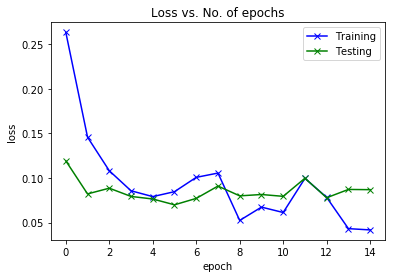

In [26]:
plot_losses(losses_train,losses_test)

## Activation Map

In [32]:
activation_map.shape

torch.Size([10, 4, 28, 28])

In [33]:
activation_map = torch.detach(activation_map)

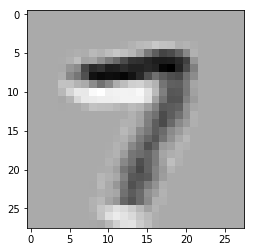

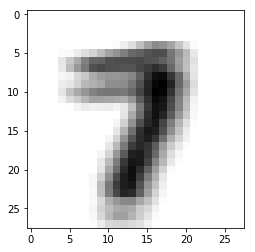

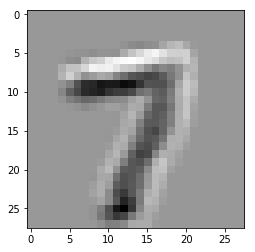

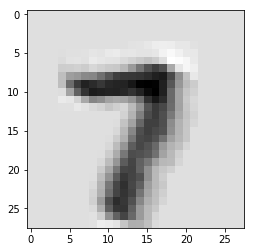

In [34]:
for i in range(4):
    plt.imshow(activation_map[0,i,:,:], cmap = 'gray')
    plt.show()

## Accuracy

In [35]:
print("Training Accuracy for Each Epoch :", accuracies_train)

Training Accuracy for Each Epoch : [90.83333333 95.83333333 96.66666667 96.16666667 97.83333333 97.16666667
 97.33333333 97.         98.33333333 97.16666667 97.66666667 96.5
 96.5        98.66666667 98.5       ]


In [36]:
print("Testing Accuracy for Each Epoch :", accuracies_test)

Testing Accuracy for Each Epoch : [95.02396249 96.80365132 96.88279905 97.17302492 97.39767873 97.45235459
 97.490514   97.14910398 97.20939942 97.41202976 97.6146143  96.86713923
 97.68032311 96.93858338 97.27507238]


In [37]:
print("Mean Testing Accuracy :", np.mean(accuracies_test) )

Mean Testing Accuracy : 97.09135004475911


## Q4. tSNE

In [38]:
from sklearn.manifold import TSNE

In [39]:
bottleneck1  = torch.detach(bottleneck1)

In [40]:
bottleneck2  = torch.detach(bottleneck2)

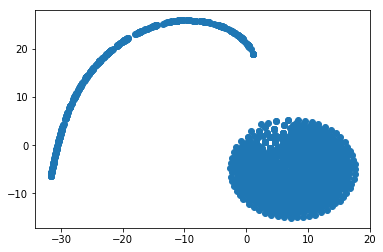

In [41]:
X_embedded = TSNE(n_components=2,init='random').fit_transform(bottleneck1.reshape(-1,1))
plt.scatter(X_embedded[:,0],X_embedded[:,1])

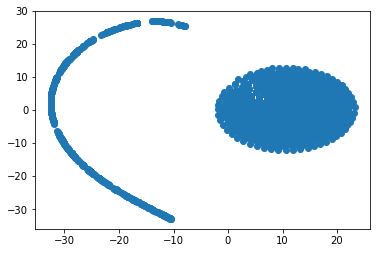

In [42]:
X_embedded = TSNE(n_components=2,init='random').fit_transform(bottleneck2.reshape(-1,1))
plt.scatter(X_embedded[:,0],X_embedded[:,1])

## Q5. Compare Result

**CNN using Numpy from Scratch:-**
</br> *for 5 Epoch :*
</br> Using Vanilla SGD : Train Accuracy = 88% and Test Accuracy = 71.4% 
</br> Using Momentum SGD : Train Accuracy = 89.9% and Test Accuracy = 74.6% 
</br> Using RMS Prop : Train Accuracy = 85.4% and Test Accuracy = 72.3% 

| Optimizer | Traning Accuracy | Testing Accuracy |
| :- | -: | :-: |
| Vanilla SGD | 88% | 71.4%
| Momentum SGD | 89.9% |74.6%
| RMS Prop | 85.4% | 74.6%



**CNN using Pytorch:-**
</br> *for 5 Epoch :*
</br> Using Vanilla SGD : Train Accuracy = 25% and Test Accuracy = 30.3% 
</br> Using Momentum SGD : Train Accuracy = 95.5% and Test Accuracy = 93.3% 
</br> Using RMS Prop : Train Accuracy = 97.6% and Test Accuracy = 97.89%

| Optimizer | Traning Accuracy | Testing Accuracy |
| :- | -: | :-: |
| Vanilla SGD | 25% | 30.3%
| Momentum SGD | 93.16% | 92.45%
| RMS Prop | 97.6% | 97.89%


## Q6. Dropout 

In [43]:
class CNN2(nn.Module):
    
    def __init__(self, dropout_rate):
        """
        Here We are initializing all the convolution Layer with Kernel Size 5*5*4 keeping the dimension same,
        Max Pool Layer with stride 2,
        Hidden Layer 1 with  49 Nodes
        Output Layer with 10 Nodes
        
        """
        super(CNN2, self).__init__()
        
        # Convolution Layer 1 with input channel =1 , output channels  = 4 , Kernel Size = 5*5 , Padding as 2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
        # ReLU activation
        self.relu1 = nn.ReLU()
        
        # Max Pooling with Size = 2 and stride = 2
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        # Convolution Layer 2 with input channel =4 , output channels  = 4 , Kernel Size = 5*5 , Padding as 2
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        
        # Max Pooling with Size = 2 and stride = 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        
        # Flatten Layer:- 7x7x4 --> 196x1
        self.flatten = nn.Flatten()
        
        # Hidden Layer 1 with 49 Node 
        self.fullyconnected1 = nn.Linear(7*7*4, 49)
        # Relu Activation
        self.relumlp = nn.ReLU()
        
        # Hidden Layer 2 with 10 Output Nodes
        self.fullyconnected2 = nn.Linear(49, 10)
        
        self.dropout_rate = dropout_rate
        
    def forward(self, out):
        """
        Convolution layer 1 --> Relu --> Maxpooling Layer 1 --> Convolution Layer 2 --> Relu --> MaxPooling Layer 2
            --> Flattening Layer --> Hidden Layer 1 --> ReLU --> Dropout --> Softmax --> Output (1*10)
            
        Input:- Ouptput from the previous Layer
        Return :- FCL output
            
        """
        
        
        out = self.conv1(out)# Convolution Layer Output 1
        self.activation1=out# Activation Layer 1 
        out = self.relu1(out)# ReLU output
        out = self.maxpool1(out)# MaxPool Output
        
        
        out = self.conv2(out) # Convolution Layer output 2 
        self.activation2=out# Activation Layer 2
        out = self.relu2(out) 
        out = self.maxpool2(out)
        
        
        out = out.view(out.size(0), -1)# Flattening Layer Output
        self.bottleneck=out # Bottleneck Output 
        
        out = self.fullyconnected1(out)# Hidden Layer  1
        
        out = self.relumlp(out)
        
        
        out = F.dropout(out , p =self.dropout_rate, training=self.training)

        out=self.fullyconnected2(out) # Output Layer 2
        
        # SOFTMAX
        out = F.log_softmax(out, dim = 1)
        
        return out

In [44]:
"""
Traning the Model

Optimizer = 'vanilla SGD', ' momentum' , 'RMS prop'
dropout_rate = 0.2, 0.5 , 0.8

"""
n_epoch  = 15
Optimizer = 'RMS prop'
dropout_rate = 0.8

model2=CNN2(dropout_rate)

accuracies_train, losses_train,accuracies_test, losses_test= train_test(model2, Optimizer ,train_data, n_epoch)

EPOCH:  1
Training Set Loss: 2.3002785444259644 , Accuracy: 12.666666666666666
Testing Set Loss: 2.3015949556827544 , Accuracy: 11.61731404876709
EPOCH:  2
Training Set Loss: 2.2946015199025473 , Accuracy: 12.833333333333334
Testing Set Loss: 2.301904798269272 , Accuracy: 11.61731404876709
EPOCH:  3
Training Set Loss: 1.3293647368748982 , Accuracy: 50.5
Testing Set Loss: 1.1102441069185733 , Accuracy: 56.02035531234741
EPOCH:  4
Training Set Loss: 1.054381916920344 , Accuracy: 58.0
Testing Set Loss: 1.0042339135482907 , Accuracy: 60.57124594116211
EPOCH:  5
Training Set Loss: 0.9615204830964407 , Accuracy: 59.833333333333336
Testing Set Loss: 0.9850604901835323 , Accuracy: 62.2595915145874
EPOCH:  6
Training Set Loss: 1.090970903635025 , Accuracy: 59.5
Testing Set Loss: 0.9325485803037882 , Accuracy: 63.16584680557251
EPOCH:  7
Training Set Loss: 0.9570603668689728 , Accuracy: 62.833333333333336
Testing Set Loss: 0.8959262805730105 , Accuracy: 64.81595352172852
EPOCH:  8
Training Set L

**Comparing with and without droupout layer**
- Without using the droupout layer we face a problem of overfitting
- Using the dropout layer the problem of overfitting can be resolve
- Using dropout Layer the Losses are decreased and Accuracy is increased

## Q7. Batch Normalization 

In [45]:
class CNN3(nn.Module):
    
    def __init__(self, dropout_rate):
        """
        Here We are initializing all the convolution Layer with Kernel Size 5*5*4 keeping the dimension same,
        Max Pool Layer with stride 2,
        Hidden Layer 1 with  49 Nodes
        Output Layer with 10 Nodes
        
        """
        super(CNN3, self).__init__()
        
        # Convolution Layer 1 with input channel =1 , output channels  = 4 , Kernel Size = 5*5 , Padding as 2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1, padding=2)
        # ReLU activation
        self.relu1 = nn.ReLU()
        
        # Max Pooling with Size = 2 and stride = 2
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        # Convolution Layer 2 with input channel =4 , output channels  = 4 , Kernel Size = 5*5 , Padding as 2
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        
        # Max Pooling with Size = 2 and stride = 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        
        # Flatten Layer:- 7x7x4 --> 196x1
        self.flatten = nn.Flatten()
        
        # Hidden Layer 1 with 49 Node 
        self.fullyconnected1 = nn.Linear(7*7*4, 49)
        # Relu Activation
        self.relumlp = nn.ReLU()
        
        self.batchNorm=nn.BatchNorm1d(49)
        
        # Hidden Layer 2 with 10 Output Nodes
        self.fullyconnected2 = nn.Linear(49, 10)
        
        self.dropout_rate = dropout_rate
        
    def forward(self, out):
        """
        Convolution layer 1 --> Relu --> Maxpooling Layer 1 --> Convolution Layer 2 --> Relu --> MaxPooling Layer 2 --
            --> Flattening Layer --> Hidden Layer 1 --> ReLU --> dropout --> Batch Norm --> Softmax --> Output (1*10)
            
        Input:- Ouptput from the previous Layer
        Return :- FCL output
            
        """
        
        
        out = self.conv1(out)# Convolution Layer Output 1
        self.activation1=out# Activation Layer 1 
        out = self.relu1(out)# ReLU output
        out = self.maxpool1(out)# MaxPool Output
        
        
        out = self.conv2(out) # Convolution Layer output 2 
        self.activation2=out# Activation Layer 2
        out = self.relu2(out) 
        out = self.maxpool2(out)
        
        
        out = out.view(out.size(0), -1)# Flattening Layer Output
        self.bottleneck=out # Bottleneck Output 
        
        out = self.fullyconnected1(out)# Hidden Layer  1
        
        out = self.relumlp(out)
        
        # BATCH NORMALIZATION
        out=self.batchNorm(out)
        
        # DROPOUT LAYER
        out = F.dropout(out , p =self.dropout_rate, training=self.training)

        out=self.fullyconnected2(out) # Output Layer 2
        
        # SOFTMAX
        out = F.log_softmax(out, dim = 1)
        
        return out

In [46]:
"""
Traning the Model

Optimizer = 'vanilla SGD', ' momentum' , 'RMS prop'

"""
n_epoch  = 15
Optimizer = 'vanilla SGD'
dropout_rate = 0.2
model3=CNN3(dropout_rate)

accuracies_train, losses_train,accuracies_test, losses_test= train_test(model3, Optimizer ,train_data, n_epoch)

EPOCH:  1
Training Set Loss: 1.5273364186286926 , Accuracy: 61.5
Testing Set Loss: 1.2856078498959542 , Accuracy: 68.87012335205078
EPOCH:  2
Training Set Loss: 1.079742670059204 , Accuracy: 77.0
Testing Set Loss: 0.9965055792927742 , Accuracy: 75.75139652252197
EPOCH:  3
Training Set Loss: 0.8696005642414093 , Accuracy: 83.83333333333333
Testing Set Loss: 0.8235004968643188 , Accuracy: 80.60775825500488
EPOCH:  4
Training Set Loss: 0.6510159770647684 , Accuracy: 88.0
Testing Set Loss: 0.6990953193902969 , Accuracy: 83.45905433654785
EPOCH:  5
Training Set Loss: 0.578010102113088 , Accuracy: 89.66666666666667
Testing Set Loss: 0.6178418345600366 , Accuracy: 84.42182585144043
EPOCH:  6
Training Set Loss: 0.5176542550325394 , Accuracy: 90.33333333333333
Testing Set Loss: 0.5505217489749193 , Accuracy: 86.07840018463135
EPOCH:  7
Training Set Loss: 0.4542004366715749 , Accuracy: 90.0
Testing Set Loss: 0.49698252450674774 , Accuracy: 87.20893440246581
EPOCH:  8
Training Set Loss: 0.4253559

**Comparing**

- Using the Batch Normalize layer we require less epoch
- good accuracy is reached in less number of epoch
